# Предсказание количества такси

**Цели проекта:**
Построить модель для предсказания количества заказов такси на следующий час.

**План проекта:**
1. Загрузка данных;
2. Анализ данных;
3. Обучение моделей;
4. Выбор лучшей модели;
5. Общие выводы.

In [1]:
# установка бибилеотек

!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.2 MB/s eta 0:00:00


In [2]:
# импорт бибилеотек

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose


RANDOM_STATE = 42
TEST_SIZE = 0.10
UNKNOWN_CATEGORY = -1

## Загрузка данных

In [3]:
# чтение данных
data = pd.read_csv(
    'https://code.s3.yandex.net/datasets/taxi.csv',
    index_col=[0],
    parse_dates=[0]
)

data.sort_index(inplace=True)

In [4]:
data.info()
display(data.head())
data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


### Выводы:
- Данные соответствуют описанию;
- Пропусков не наблюдается;
- Данные хранят записи от 2018-03-01 00:00:00 до 2018-08-31 23:50:00.

## Анализ данных

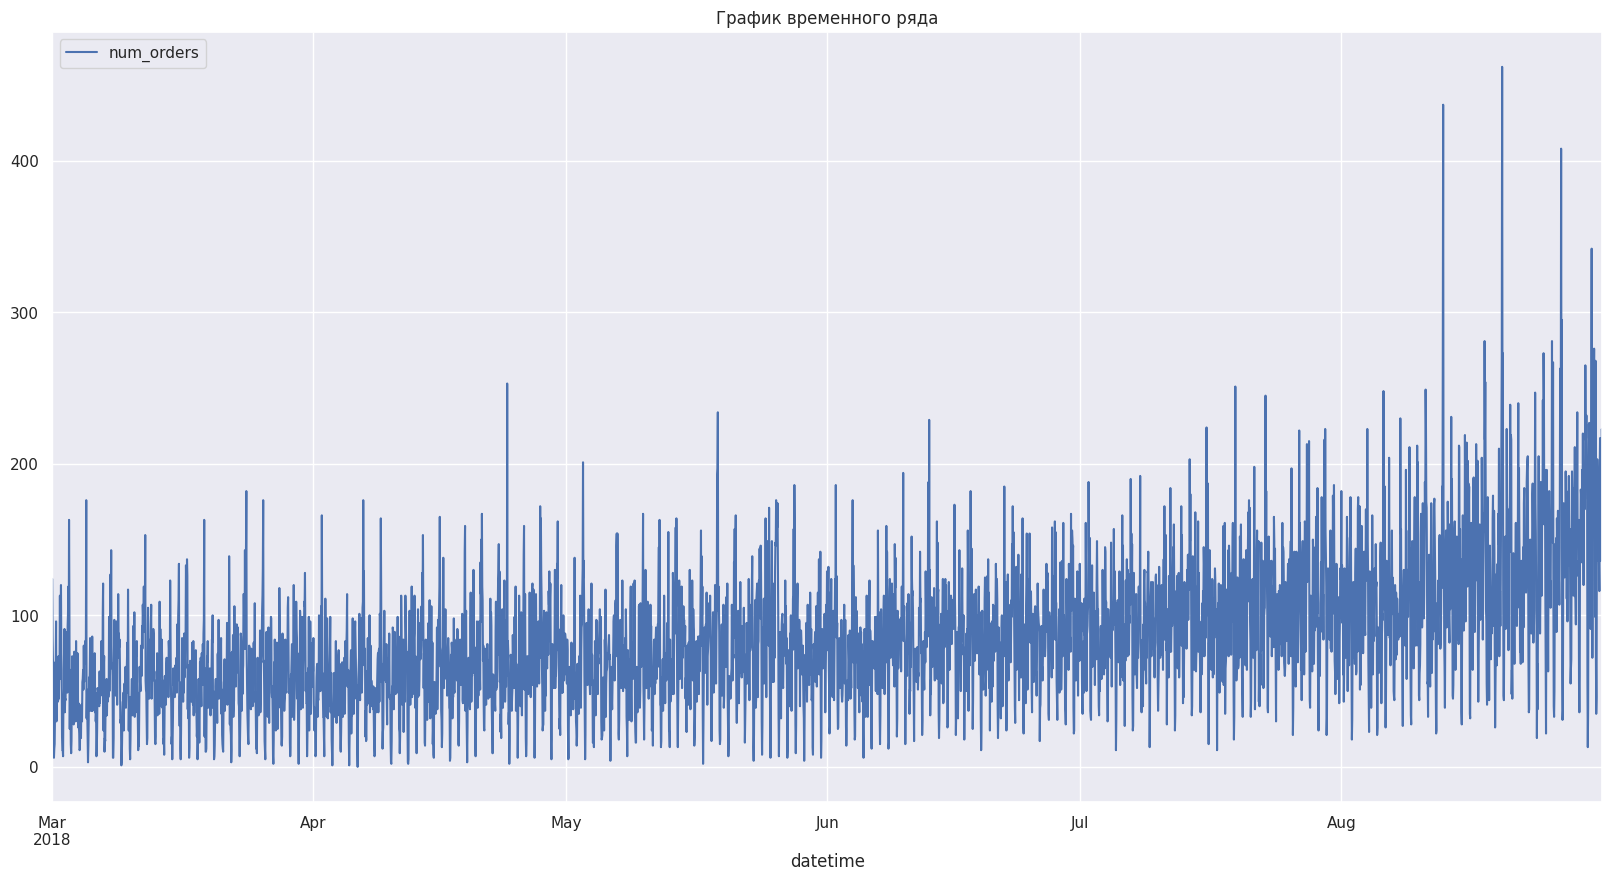

In [5]:
data_resample_1h = data.resample('1H').sum()

sns.set(rc={"figure.figsize": (20, 10)})
data_resample_1h.plot()
plt.title('График временного ряда');

График в таком масштабе не информативный. Рассмотрим срез данных за неделю.

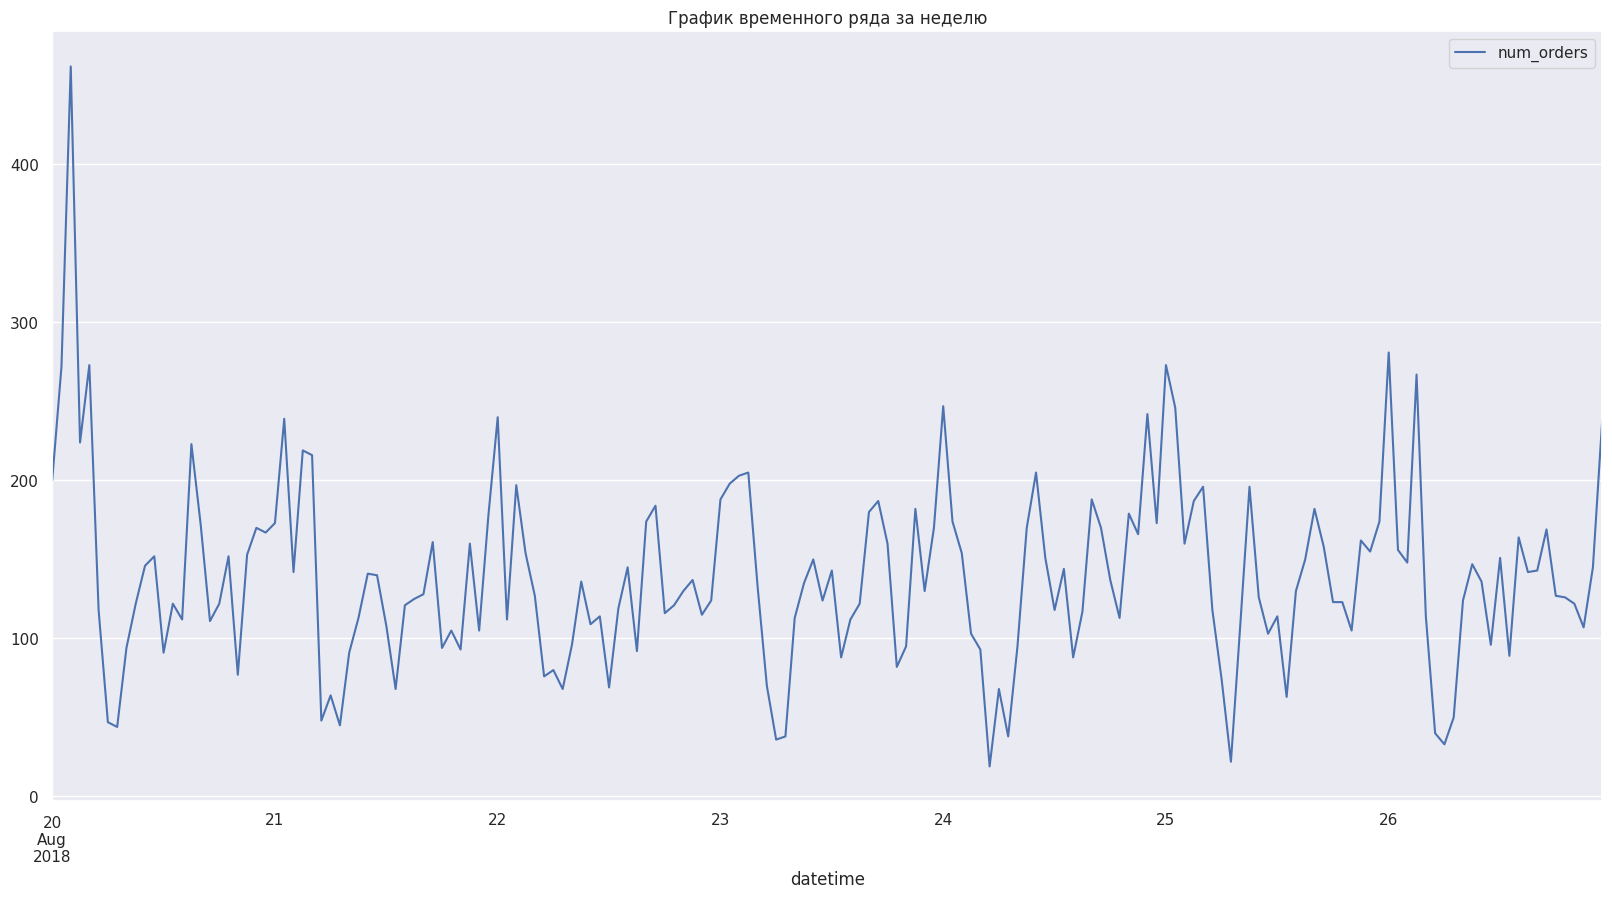

In [6]:
data_resample_1h['2018-08-20':'2018-08-26'].plot()
plt.title('График временного ряда за неделю');

### Декомпозиция данных

In [7]:
decomposed = seasonal_decompose(data_resample_1h)

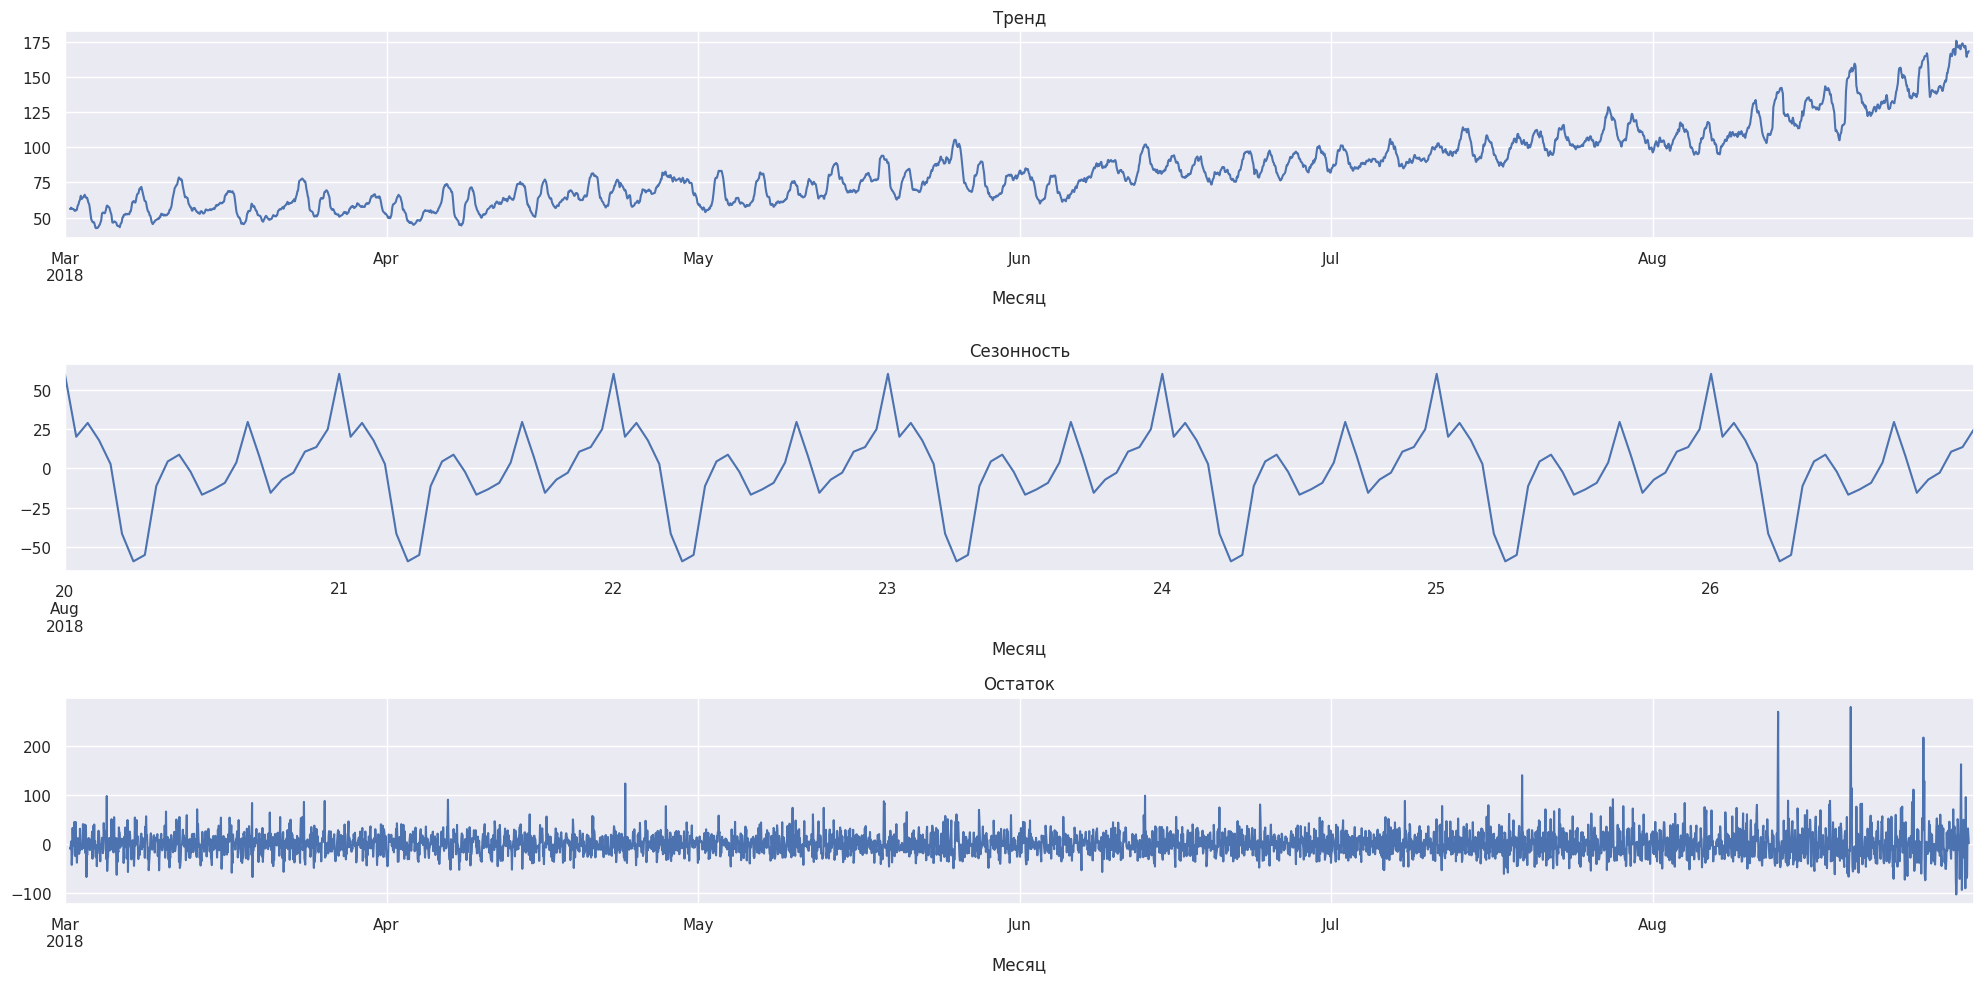

In [8]:
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Месяц')
plt.subplot(312)
decomposed.seasonal['2018-08-20':'2018-08-26'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Месяц')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.xlabel('Месяц')
plt.tight_layout()

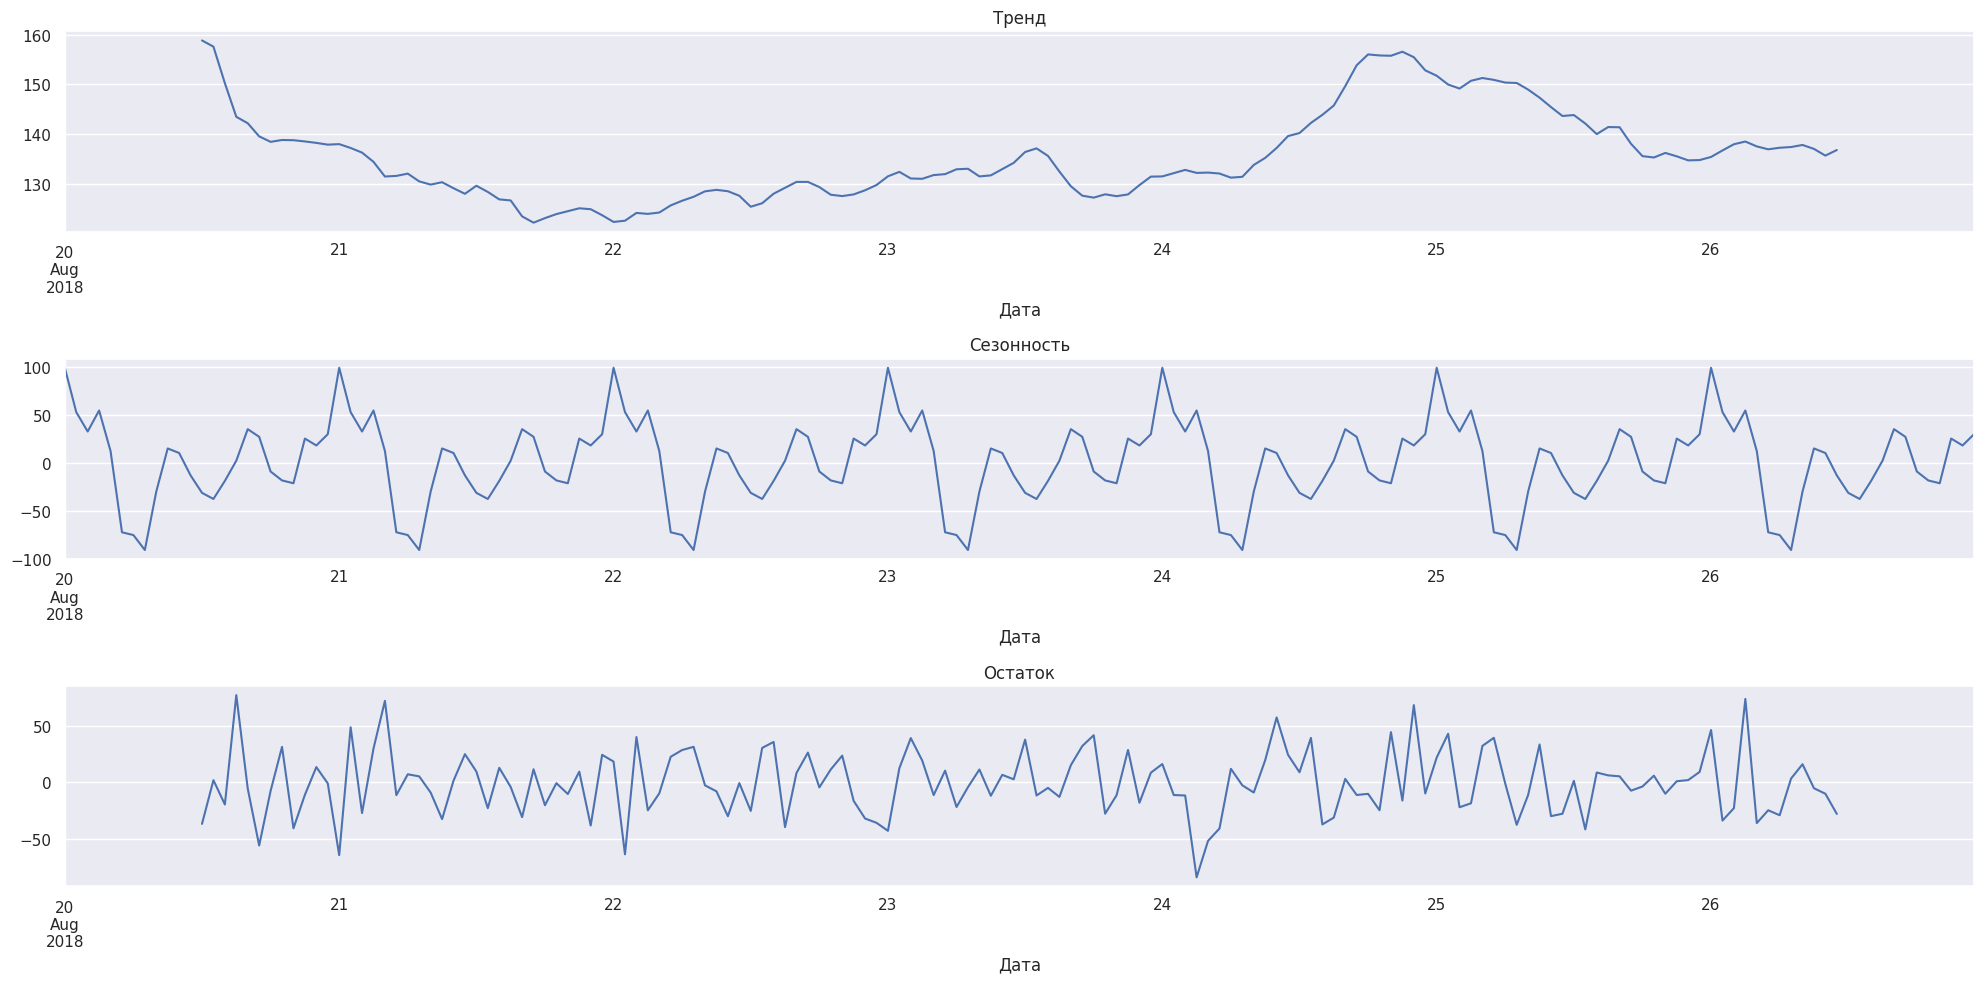

In [9]:
# Декомпозиция на данных за неделю
decomposed_week = seasonal_decompose(data_resample_1h['2018-08-20':'2018-08-26'])

plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.xlabel('Дата')
plt.tight_layout()

### Выводы:
- Анализ всех данных иллюстрирует рост общего тренда;
- Временной ряд подвержен тренду, который меняется со временем и не является стационарным;
- Анализ данных за 2018-08-20 - 2018-08-26 говорит о росте количества заказов в утреннее время и спад в течение дня.

## Обучение моделей

In [10]:
# Функция для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [11]:
# Применение функции для создания признаков
make_features(data_resample_1h, max_lag=24, rolling_mean_size=24)

In [12]:
# Разделение на обучающую и тестовую выборки
train, test = train_test_split(data_resample_1h, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()
test = test.dropna()

# Выделение признаков и целевого признака
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

### LinearRegression

In [13]:
pipeline_lr = Pipeline([
    ('preprocessor', RobustScaler()),
    ('model', LinearRegression())
])

# Использование TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Оценка модели с использованием TimeSeriesSplit и метрики neg_root_mean_squared_error
rmse_lr = cross_val_score(pipeline_lr,
                          X_train,
                          y_train,
                          cv=tscv,
                          scoring='neg_root_mean_squared_error').mean() * -1

print('Среднее значение RMSE для LinearRegression =', rmse_lr)

Среднее значение RMSE для LinearRegression = 27.133933268367304


### RandomForestRegressor

In [14]:
pipeline_rf = Pipeline([
    ('preprocessor', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=10,
                                    n_jobs=-1,
                                    random_state=RANDOM_STATE))
])

# Использование TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Оценка модели с использованием TimeSeriesSplit и метрики neg_root_mean_squared_error
rmse_rf = cross_val_score(pipeline_rf,
                                X_train,
                                y_train,
                                cv=tscv,
                                scoring='neg_root_mean_squared_error').mean() * -1
print('Среднее значение RMSE для RandomForest =', rmse_rf)

Среднее значение RMSE для RandomForest = 26.701241514629288


### CatBoostRegressor

In [15]:
model_cbr = CatBoostRegressor(learning_rate=0.5,
                              iterations=10,
                              depth=10,
                              random_state=RANDOM_STATE,
                              verbose=False)

# Использование TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Оценка модели с использованием TimeSeriesSplit и метрики neg_root_mean_squared_error
rmse_cbr = cross_val_score(model_cbr,
                                X_train,
                                y_train,
                                cv=tscv,
                                scoring='neg_root_mean_squared_error').mean() * -1
print('Среднее значение RMSE для CatBoostRegressor =', rmse_cbr)

Среднее значение RMSE для CatBoostRegressor = 27.315321473106405


### LightGBM

In [16]:
model_lgbm = LGBMRegressor(
    learning_rate=0.3,
    random_state=42,
    n_jobs=-1,
    verbose=0,
    reg_lambda=0.1,
    min_child_samples=5,
    min_child_weight=1
)

# Гиперпараметры для поиска
hyperparams = {
    'num_leaves': [50, 100],
    'max_depth': [5, 10]
}

# Использование TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Поиск лучших параметров с помощью GridSearchCV
clf = GridSearchCV(
    model_lgbm,
    hyperparams,
    scoring='neg_root_mean_squared_error',
    cv=tscv
)

clf.fit(X_train, y_train)

print("Лучшие гиперпараметры:")
print(clf.best_params_)

model_lgbm = clf.best_estimator_
rmse_lgbm = clf.best_score_ * -1
print('Среднее значение RMSE для LightGBM =', rmse_lgbm)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## Выбор лучшей модели

In [17]:
# Функция для измерения времени выполнения кода
def measure_time(func):
    start = time.time()
    result = func()
    end = time.time()
    return result, (end - start)

# Оценка моделей
models_results = {}

In [18]:
# LinearRegression
train_time_lr = measure_time(lambda: pipeline_lr.fit(X_train, y_train))
pred_time_lr = measure_time(lambda: pipeline_lr.predict(X_train))
models_results['LinearRegression'] = {
    'model': pipeline_lr,
    'RMSE': rmse_lr,
    'train_time': train_time_lr[1],
    'pred_time': pred_time_lr[1]}

In [19]:
# RandomForestRegressor
train_time_rf = measure_time(lambda: pipeline_rf.fit(X_train, y_train))
pred_time_rf = measure_time(lambda: pipeline_rf.predict(X_train))
models_results['RandomForestRegressor'] = {
    'model': pipeline_rf,
    'RMSE': rmse_rf,
    'train_time': train_time_rf[1],
    'pred_time': pred_time_rf[1]}

In [20]:
# CatBoostRegressor
train_time_cbr = measure_time(lambda: model_cbr.fit(X_train, y_train))
pred_time_cbr = measure_time(lambda: model_cbr.predict(X_train))
models_results['CatBoostRegressor'] = {
    'model': model_cbr,
    'RMSE': rmse_cbr,
    'train_time': train_time_cbr[1],
    'pred_time': pred_time_cbr[1]}

In [21]:
# LightGBM
train_time_lgbm = measure_time(lambda: model_lgbm.fit(X_train, y_train))
pred_time_lgbm = measure_time(lambda: model_lgbm.predict(X_train))
models_results['LGBMRegressor'] = {
    'model': model_lgbm,
    'RMSE': rmse_lgbm,
    'train_time': train_time_lgbm[1],
    'pred_time': pred_time_lgbm[1]}

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [22]:
# Сравнение моделей
def score(model):
    return (
        # Нормализация RMSE: отношение RMSE модели к минимальному RMSE среди всех моделей
        (model['RMSE'] / min(m['RMSE'] for m in models_results.values())) +
        # Нормализация времени обучения: отношение времени обучения модели к минимальному времени среди всех моделей
        (model['train_time'] / min(m['train_time'] for m in models_results.values())) +
        # Нормализация времени предсказания: отношение времени предсказания модели к минимальному времени среди всех моделей
        (model['pred_time'] / min(m['pred_time'] for m in models_results.values()))
    ) / 3 # Среднее значение нормализованных критериев

# Вычисляем оценку для каждой модели
scores = {k: score(v) for k, v in models_results.items()}

# Выводим название модели и её оценку
for model, score in scores.items():
    print(f'{model}: {score}')

LinearRegression: 1.7015037278212322
RandomForestRegressor: 15.829223648406504
CatBoostRegressor: 10.154964529891787
LGBMRegressor: 6.017112756369613


**Нормализация RMSE:** Мы делим RMSE каждой модели на минимальный RMSE среди всех моделей. Это позволяет определить, насколько модель хуже или лучше по сравнению с самой точной моделью.

**Нормализация времени обучения:** Аналогично, делим время обучения каждой модели на минимальное время обучения среди всех моделей. Это позволяет оценить эффективность обучения каждой модели.

**Нормализация времени предсказания:** Мы делим время предсказания каждой модели на минимальное время предсказания среди всех моделей. Это позволяет оценить скорость предсказания.

**Среднее значение нормализованных критериев:** Мы усредняем нормализованные значения всех трёх критериев. Модель с наименьшей средней оценкой будет выбрана как лучшая.

In [23]:
# Выбор лучшей модели и тестирование её на тестовой выборке
best_model_name = min(scores, key=scores.get)
best_model = models_results[best_model_name]['model']

# Окончательная оценка на тестовой выборке
predictions, test_time = measure_time(lambda: best_model.predict(X_test))
final_rmse_test = mean_squared_error(y_test, predictions) ** 0.5

print(f'Лучшей моделью оказалась {best_model_name}')
print(f'RMSE на тестовой выборке = {final_rmse_test}')
print(f'Время предсказания на тестовой выборке = {test_time} секунд')

Лучшей моделью оказалась LinearRegression
RMSE на тестовой выборке = 45.17810328481286
Время предсказания на тестовой выборке = 0.0076770782470703125 секунд


## Общие выводы

1. **Загрузка и изучение данных:**

    Были загружены данные о количествах заказов такси. Проведён первоначальный анализ данных.


2. **Анализ данных:**

- Выявлен рост общего тренда;
- Временной ряд не является стационарным;
- Количества заказов в утреннее время растет и спадает в течение дня.


3. **Обучение моделей:**

    Были обучены несколько моделей машинного обучения: LinearRegression, RandomForestRegressor, CatBoostRegressor и LGBMRegressor. Модели были обучены на подготовленных данных с последующей оценкой их точности.


4. **Сравнение моделей и выбор лучшей:**

    Проведено сравнение моделей на основе метрики RMSE (Root Mean Squared Error). Выбрана модель, показавшая наилучшие результаты, с минимальной ошибкой предсказания.


5. **Итоговые выводы:**

    В результате проведённого анализа и моделирования была выбрана лучшая модель (LinearRegression) с RMSE на тестовой выборке = 45.17, которая способна предсказать количество заказов такси.